<a href="https://colab.research.google.com/github/Vaibhav67979/Ecommerce-product-recommendation-system/blob/main/rank_based_product_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#E-commerce Product recommendation System

In [1]:
# prompt: Mount drive

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


##Importing libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity

from sklearn.metrics import mean_squared_error

## Importing Dataset

In [3]:
#Import the data set
df = pd.read_csv('/content/drive/MyDrive/Data/Magazine data/ratings_Electronics.csv', header=None) #There are no headers in the data file

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp'] #Adding column names

df = df.drop('timestamp', axis=1) #Dropping timestamp

df_copy = df.copy(deep=True) #Copying the data to another dataframe

## EDA - Exploratory Data Analysis

check for -
- shape
- datatype
- missing values


finally get the summary and check
- rating distribution.
- number of users and products.
- Users with highest no of ratings.

### Shape

In [4]:
rows, columns = df.shape
print("No of rows = ", rows)
print("No of columns = ", columns)

No of rows =  7824482
No of columns =  3


### Datatypes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   user_id  object 
 1   prod_id  object 
 2   rating   float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


### Missing value analysis

In [6]:
# Find number of missing values in each column
df.isna().sum()

,0
user_id,0
prod_id,0
rating,0


### Summary

In [7]:
# Summary statistics of 'rating' variable
df['rating'].describe()

,rating
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


### Rating distribution

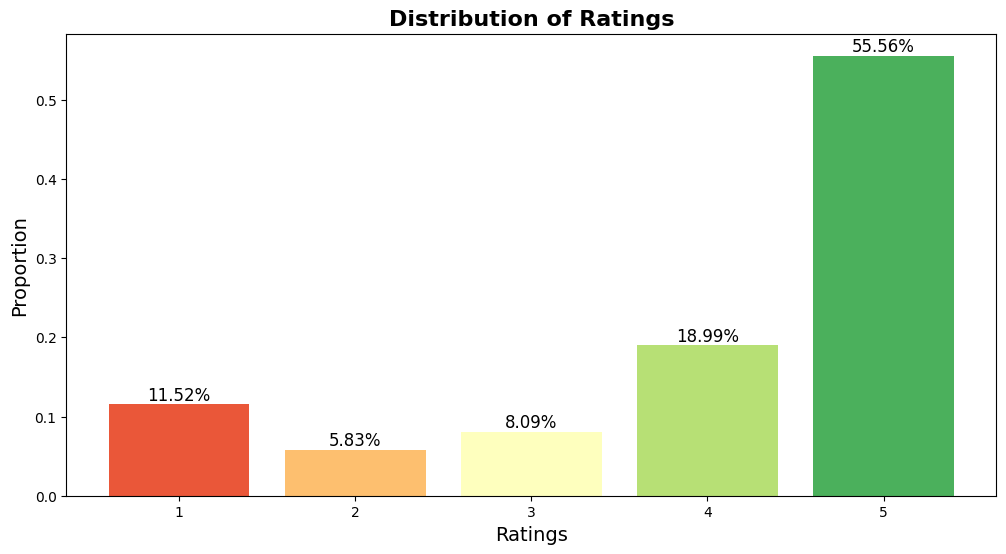

In [8]:
#Create the plot and provide observations

# plt.figure(figsize = (12,6))
# df['rating'].value_counts(1).plot(kind='bar')
# plt.show()
# Sort ratings in ascending order
rating_counts = df['rating'].value_counts(normalize=True).sort_index()

# Define colors using a gradient (from red to green)
colors = sns.color_palette("RdYlGn", len(rating_counts))

# Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(rating_counts.index, rating_counts.values, color=colors)

# Add percentage labels on bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2,
             bar.get_height(),
             f'{bar.get_height():.2%}',
             ha='center', va='bottom', fontsize=12)

# Labels and title
plt.xlabel("Ratings", fontsize=14)
plt.ylabel("Proportion", fontsize=14)
plt.title("Distribution of Ratings", fontsize=16, fontweight='bold')
plt.xticks(rotation=0)  # Keep x-axis labels readable
plt.savefig("ratings_distribution.png", dpi=300, bbox_inches='tight')
# Show
plt.show()

The distribution is skewed to the right. Over 50% of the ratings are 5, followed by a little below 20% with 4 star ratings. And the percentages of ratings keep going down until below 10% of the ratings are 2 stars.

### No of unique users and items

In [9]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


### Users with most no of rating

In [10]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

,0
user_id,
A5JLAU2ARJ0BO,520
ADLVFFE4VBT8,501
A3OXHLG6DIBRW8,498
A6FIAB28IS79,431
A680RUE1FDO8B,406
A1ODOGXEYECQQ8,380
A36K2N527TXXJN,314
A2AY4YUOX2N1BQ,311
AWPODHOB4GFWL,308


## Pre-Processing

Let's take a subset of the dataset (by only keeping the users who have given 50 or more ratings) to make the dataset less sparse and easy to work with.

In [11]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [12]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique PRODUCTS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique PRODUCTS in the final data =  48190


- The dataframe **df_final has users who have rated 50 or more items**
- **We will use df_final to build recommendation systems**

### Checking the density of the rating matrix

In [13]:
#Creating the interaction matrix of products and users based on ratings and replacing NaN value with 0
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

#Finding the number of non-zero entries in the interaction matrix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)

#Finding the possible number of ratings as per the number of users and products
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)

#Density of ratings
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
print(df_final['prod_id'].dtype)  # Check if it's object/string
print(df_final['prod_id'].head())  # Inspect some values
df_final['prod_id'] = df_final['prod_id'].astype(str)

object
94     0594451647
118    0594481813
177    0970407998
178    0970407998
492    0972683275
Name: prod_id, dtype: object


In [15]:
print(df_final.groupby('prod_id')['rating'].apply(lambda x: x.mean()))

prod_id
0594451647    5.000000
0594481813    3.000000
0970407998    2.500000
0972683275    4.750000
1400501466    3.333333
                ...   
B00LED02VY    4.000000
B00LGN7Y3G    5.000000
B00LGQ6HL8    5.000000
B00LI4ZZO8    4.500000
B00LKG1MC8    5.000000
Name: rating, Length: 48190, dtype: float64


# Rank Based Recommendation System

In [16]:
# Convert rating to numeric, forcing errors to NaN


# Drop NaN values if any exist after conversion
df_final = df_final.dropna(subset=['rating'])


#Calculate the average rating for each product
average_rating = df_final.groupby('prod_id')['rating'].mean()

#Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id').count()['rating']

#Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

#Sort the dataframe by average of ratings
final_rating = final_rating.sort_values(by='avg_rating',ascending=False)

final_rating.head()

,avg_rating,rating_count
prod_id,,
0594451647,5.0,1
B003RRY9RS,5.0,1
B003RR95Q8,5.0,1
B003RIPMZU,5.0,1
B003RFRNYQ,5.0,2


In [17]:
#defining a function to get the top n products based on highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):

    #Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count']>min_interaction]

    #Sorting values w.r.t average rating
    recommendations = recommendations.sort_values('avg_rating',ascending=False)

    return recommendations.index[:n]

## Recommend Top 10 with 20 minimum interactions

In [18]:
list(top_n_products(final_rating, 10, 20))

['B0052SCU8U',
 'B0046TJG1U',
 'B00BW6KCTU',
 'B003ES5ZR8',
 'B001TH7T2U',
 'B005ES0YYA',
 'B003FVJYF8',
 'B00BQ4F9ZA',
 'B009USAJCC',
 'B0000X0VCY']

## Recommend Top 10 products with 50 minimum interactions

In [19]:
list(top_n_products(final_rating, 10, 100))

['B003ES5ZUU',
 'B000N99BBC',
 'B007WTAJTO',
 'B002V88HFE',
 'B004CLYEDC',
 'B00834SJSK',
 'B0034CL2ZI',
 'B00834SJNA',
 'B00829TIEK',
 'B00829THK0']

In [20]:


# Hit Rate (HR@N)
def hit_rate(recommended_items, actual_purchases):
    hits = sum(1 for item in actual_purchases if item in recommended_items)
    return hits / len(actual_purchases) if actual_purchases else 0

# Precision@N
def precision_at_n(recommended_items, actual_purchases, n):
    hits = sum(1 for item in recommended_items if item in actual_purchases)
    return hits / n

# Recall@N
def recall_at_n(recommended_items, actual_purchases):
    hits = sum(1 for item in recommended_items if item in actual_purchases)
    return hits / len(actual_purchases) if actual_purchases else 0

# Mean Reciprocal Rank (MRR)
def mean_reciprocal_rank(recommended_items, actual_purchases):
    for i, item in enumerate(recommended_items):
        if item in actual_purchases:
            return 1 / (i + 1)  # Rank starts from 1
    return 0

# Coverage
def coverage(recommended_lists, all_products):
    recommended_products = set(item for sublist in recommended_lists for item in sublist)
    return len(recommended_products) / len(all_products)


In [21]:
# Sample actual purchases (simulating user interactions)
user_actual_purchases = {
    "user1": ['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'],
}

# Get recommendations using your function
top_5_products = list(top_n_products(final_rating, 5, 50))

# Compute metrics for each user
hr_scores = []
precision_scores = []
recall_scores = []
mrr_scores = []

for user, actual_purchases in user_actual_purchases.items():
    hr_scores.append(hit_rate(top_5_products, actual_purchases))
    precision_scores.append(precision_at_n(top_5_products, actual_purchases, 5))
    recall_scores.append(recall_at_n(top_5_products, actual_purchases))
    mrr_scores.append(mean_reciprocal_rank(top_5_products, actual_purchases))

# Compute final scores (average across users)
final_hr = np.mean(hr_scores)
final_precision = np.mean(precision_scores)
final_recall = np.mean(recall_scores)
final_mrr = np.mean(mrr_scores)

# Calculate coverage
all_products = set(final_rating.index)  # All products in dataset
final_coverage = coverage([top_5_products], all_products)

# Print evaluation results
print(f"Hit Rate (HR@5): {final_hr:.4f}")
print(f"Precision@5: {final_precision:.4f}")
print(f"Recall@5: {final_recall:.4f}")
print(f"Mean Reciprocal Rank (MRR): {final_mrr:.4f}")
print(f"Coverage: {final_coverage:.4f}")


Hit Rate (HR@5): 1.0000
Precision@5: 1.0000
Recall@5: 1.0000
Mean Reciprocal Rank (MRR): 1.0000
Coverage: 0.0001
